In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from umap.parametric_umap import ParametricUMAP

2024-10-07 02:52:26.618079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 02:52:26.621109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 02:52:26.630984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 02:52:26.646774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 02:52:26.651278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 02:52:26.662871: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
data = np.load("data/ihb.npy")

In [ ]:
# Check the shape of the data
print("Original shape:", data.shape)  # Should be (320, 10, 246)

# Create a mask to identify samples with NaNs in the last dimension
mask_nan = np.isnan(data).any(axis=(1, 2))

# Split the data into two arrays
data_no_nans = data[~mask_nan]  # Samples without NaNs
data_with_nans = data[mask_nan][:, :, :200]  # Samples with NaNs

Original shape: (320, 10, 246)


In [ ]:
mask_nan

array([False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True, False, False,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True,  True, False,
       False, False,

In [ ]:
# Output shapes of the split arrays
print("Shape of data without NaNs:", data_no_nans.shape)
print("Shape of data with NaNs:", data_with_nans.shape)

Shape of data without NaNs: (160, 10, 246)
Shape of data with NaNs: (160, 10, 200)


In [ ]:
# Assuming you have the following data:
# atlas1 of shape (160, 10, 246)
# atlas2 of shape (160, 10, 200)
# Randomly generated for illustration
np.random.seed(42)
atlas1 = data_no_nans  # Shape: (160, 10, 246)
atlas2 = data_with_nans  # Shape: (160, 10, 200)


# Function to compute cross-correlation for two time series using np.corrcoef
def compute_cross_correlation(ts_a, ts_b):
    # Combine the two sets of time series and compute the correlation matrix
    combined = np.vstack([ts_a, ts_b])
    corr_matrix = np.corrcoef(combined)

    # Extract cross-correlation part between ts_a and ts_b
    cross_corr_matrix = corr_matrix[: ts_a.shape[0], ts_a.shape[0] :]

    return cross_corr_matrix


# Create a list to store flattened cross-correlation matrices for all scans
cross_corr_features = []

# Loop over each scan in the atlases
for scan_index in range(atlas1.shape[0]):  # 160 scans
    # Get the time series for the current scan
    ts_atlas1 = atlas1[scan_index]  # Shape: (10, 246)
    ts_atlas2 = atlas2[scan_index]  # Shape: (10, 200)

    # Compute the cross-correlation matrix
    cross_corr_matrix = compute_cross_correlation(
        ts_atlas1.T, ts_atlas2.T
    )  # Transpose to shape (246, 10) and (200, 10)

    # Flatten the entire cross-correlation matrix
    flattened_features = cross_corr_matrix.flatten()  # Shape: (246 * 200,)

    # Append the feature vector to the list
    cross_corr_features.append(flattened_features)

# Convert to DataFrame for easier manipulation
cross_corr_features_df = pd.DataFrame(cross_corr_features)

# Concatenate the DataFrame with itself to account for the second half of the dataset (160 + 160 = 320)
cross_corr_features_df_expanded = pd.concat(
    [cross_corr_features_df, cross_corr_features_df]
)

# Reset index and display the shape of the resulting feature DataFrame
print(
    f"Shape of the expanded cross-correlation features DataFrame: {cross_corr_features_df_expanded.shape}"
)

Shape of the expanded cross-correlation features DataFrame: (320, 49200)


In [ ]:
cross_corr_features_df_expanded.to_numpy().shape

(320, 49200)

In [ ]:
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)

    # Z-normalize the data
    normalized_data = (data - mean) / std

    # The shape of normalized_data will be (160, 10, 246)
    return normalized_data


data_no_nans = normalize(data_no_nans)
data_with_nans = normalize(data_with_nans)

In [ ]:
def get_corr_matrics(some_data):

    correlation_matrices = []

    # Loop over each scan
    for i in range(some_data.shape[0]):
        # Get the time series for all brain regions in this scan (shape: 10, 246)
        time_series = some_data[i, :, :]

        # Compute the Pearson correlation matrix (shape: 246, 246)
        corr_matrix = np.corrcoef(time_series, rowvar=False)

        # Append the correlation matrix to the list
        correlation_matrices.append(corr_matrix)

    # Convert the list to a numpy array (shape: 320, 246, 246)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return correlation_matrices

In [ ]:
def fisher_transform(corr):
    return corr
    # Clip values to avoid issues with arccosh for values very close to -1 or 1
    corr = np.clip(corr, -0.999999, 0.999999)
    return 0.5 * np.log((1 + corr) / (1 - corr))


# Assuming your correlation matrix is named `correlation_matrices`
# with shape (320, 246, 246)
# def apply_transforms(correlation_matrices):
#     # Step 1: Fisher's r-to-z transformation
#     def fisher_transform(corr):
#         # Clip values to avoid issues with arccosh for values very close to -1 or 1
#         corr = np.clip(corr, -0.999999, 0.999999)
#         return 0.5 * np.log((1 + corr) / (1 - corr))

#     # Apply Fisher transformation to each correlation matrix
#     z_matrices = fisher_transform(correlation_matrices)

#     # Step 2: Pseudo z-scoring
#     # Here we will standardize each matrix (mean = 0, std = 1)
#     def pseudo_z_score(z_matrices):
#         # Calculate mean and std along the last two dimensions (246, 246)
#         mean = np.mean(z_matrices, axis=(1, 2), keepdims=True)
#         std = np.std(z_matrices, axis=(1, 2), keepdims=True)

#         # Standardize
#         return (z_matrices - mean) / std

#     # Apply pseudo z-scoring
#     return pseudo_z_score(z_matrices)

In [ ]:
no_nans_corr = get_corr_matrics(data_no_nans)
with_nans_corr = get_corr_matrics(data_with_nans)

Shape of correlation matrices: (160, 246, 246)
Shape of correlation matrices: (160, 200, 200)


In [ ]:
# Assuming `correlation_matrices` is of shape (320, 246, 246)


# Function to extract the upper triangle of the correlation matrix, excluding the diagonal
def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]  # k=1 excludes the diagonal


# Flatten each 246x246 correlation matrix into a 1D vector (upper triangle only)
flattened_matrices_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in with_nans_corr]
)

flattened_matrices_no_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in no_nans_corr]
)

In [ ]:
print("Shape of flattened matrices with NaNs:", flattened_matrices_nans.shape)
print("Shape of flattened matrices without NaNs:", flattened_matrices_no_nans.shape)

Shape of flattened matrices with NaNs: (160, 19900)
Shape of flattened matrices without NaNs: (160, 30135)


In [ ]:
# flattened_matrices_nans = np.column_stack(
#     (flattened_matrices_nans, get_cross_corr_matrics(data_no_nans, data_with_nans))
# )

# flattened_matrices_no_nans = np.column_stack(
#     (flattened_matrices_no_nans, get_cross_corr_matrics(data_with_nans, data_no_nans))
# )

In [ ]:
# Set UMAP parameters
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 50  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_nans = umap_model_nans.fit_transform(flattened_matrices_nans)

# Apply UMAP to the data without NaN values
umap_model_no_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_no_nans = umap_model_no_nans.fit_transform(flattened_matrices_no_nans)

# Concatenate the UMAP results
flattened_matrices = np.concatenate((umap_result_nans, umap_result_no_nans), axis=0)

print("Shape of flattened matrices:", flattened_matrices.shape)

I0000 00:00:1728258751.135973  179076 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 02:52:31.137502: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3693
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3218
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3219
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3198
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3199
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3207
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3206
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3192
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3196
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3216


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.3845
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3226
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3202
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3207
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.3195
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3210
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3218
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3211
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.3197
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.3197
Shape of flattened matrices: (320, 50)


In [ ]:
flattened_matrices = np.column_stack(
    (flattened_matrices, cross_corr_features_df_expanded.to_numpy())
)
print(flattened_matrices.shape)

(320, 49250)


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


2024-10-07 02:55:04.381913: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63040000 exceeds 10% of free system memory.
2024-10-07 02:55:04.419845: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63040000 exceeds 10% of free system memory.
2024-10-07 02:55:04.615797: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63040000 exceeds 10% of free system memory.
2024-10-07 02:55:04.647245: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63040000 exceeds 10% of free system memory.
2024-10-07 02:55:07.506098: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63040000 exceeds 10% of free system memory.
/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This w

341/341 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - loss: 0.4402
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - loss: 0.4013
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - loss: 0.3962
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - loss: 0.3970
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 0.3957
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 0.3951
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 0.3947
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - loss: 0.3940
Epoch 9/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - loss: 0.3938
Epoch 10/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - loss: 0.3940


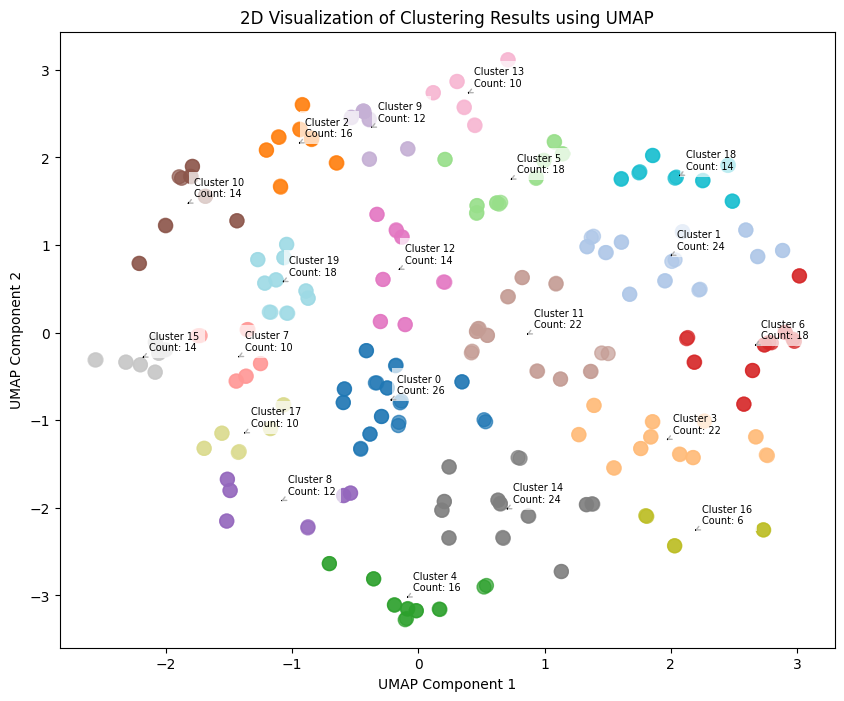

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 2 dimensions
umap_reducer = umap.ParametricUMAP(
    n_components=2,
    n_neighbors=16,
    min_dist=0.1,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("submissions/" + "bullshit10.csv", index=False)